# **Neural Networks - Gas Turbines**

Problem statement: predicting turbine energy yield (TEY) using ambient variables as features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras import Sequential

In [2]:
# Read csv file
df_turbines = pd.read_csv('gas_turbines.csv')
df_turbines.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


## **EDA - Exploratory Data Analysis**

In [3]:
df_turbines.shape

(15039, 11)

In [4]:
df_turbines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [5]:
df_turbines.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,15039.000000,15039.00000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000
mean,17.764381,1013.19924,79.124174,4.200294,25.419061,1083.798770,545.396183,134.188464,12.102353,1.972499,68.190934
std,7.574323,6.41076,13.793439,0.760197,4.173916,16.527806,7.866803,15.829717,1.103196,2.222206,10.470586
min,0.522300,985.85000,30.344000,2.087400,17.878000,1000.800000,512.450000,100.170000,9.904400,0.000388,27.765000
25%,11.408000,1008.90000,69.750000,3.723900,23.294000,1079.600000,542.170000,127.985000,11.622000,0.858055,61.303500
50%,18.186000,1012.80000,82.266000,4.186200,25.082000,1088.700000,549.890000,133.780000,12.025000,1.390200,66.601000
75%,23.862500,1016.90000,90.043500,4.550900,27.184000,1096.000000,550.060000,140.895000,12.578000,2.160400,73.935500
max,34.929000,1034.20000,100.200000,7.610600,37.402000,1100.800000,550.610000,174.610000,15.081000,44.103000,119.890000


Observation: By looking at 75% and max values of various columns, columns CO and NOX values contains huge differences for these columns. Hence, outliers of these columns can be cleared to create proper model.

In [6]:
# CO column
# IQR = Q3 - Q1 i.e. 2.16 - 0.85
# Upper limit = Q3 + 1.5 * IQR i.e. 2.16 + 1.5 * (2.16 - 0.85)
co_upper_limit = 2.16 + (1.5 * (2.16 - 0.85))
print('CO column Range Upper Limit: ', co_upper_limit)
#df_turbines.loc[df_turbines['CO']> (2.16 + 1.5 * (2.16 - 0.85))].count()
df_turbines.loc[df_turbines['CO']> 8].count()

CO column Range Upper Limit:  4.125


AT      277
AP      277
AH      277
AFDP    277
GTEP    277
TIT     277
TAT     277
TEY     277
CDP     277
CO      277
NOX     277
dtype: int64

In [7]:
# CO values greater than 8 will be removed.
df_turbines1 = df_turbines.loc[df_turbines['CO'] <= 8]
df_turbines1.shape

(14762, 11)

In [8]:
df_turbines1.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,14762.000000,14762.000000,14762.000000,14762.000000,14762.000000,14762.000000,14762.000000,14762.000000,14762.000000,14762.000000,14762.000000
mean,17.888288,1013.115899,78.990787,4.214748,25.520451,1084.598056,545.552675,134.616140,12.129633,1.777666,67.670670
std,7.551980,6.369533,13.841701,0.754100,4.136521,15.494020,7.804066,15.621018,1.092603,1.421239,9.625449
min,0.587590,985.850000,30.344000,2.105700,17.878000,1000.800000,512.450000,100.170000,9.904400,0.000388,27.765000
25%,11.578250,1008.900000,69.483250,3.744800,23.446250,1082.300000,543.122500,130.560000,11.694000,0.848477,61.173250
50%,18.369000,1012.700000,82.085000,4.198300,25.143000,1088.900000,549.900000,133.790000,12.038000,1.368700,66.441500
75%,23.941500,1016.800000,89.983750,4.561425,27.461750,1096.400000,550.060000,142.035000,12.662750,2.075450,73.358750
max,34.929000,1034.200000,100.200000,7.610600,37.402000,1100.800000,550.610000,174.610000,15.081000,7.996200,119.890000


In [9]:
# NOX column
IQR = 73.35 - 61.17 
NOX_upper_limit = 73.35 + (1.5 * IQR)
print("NOX Column Range Upper Limit ", NOX_upper_limit)

NOX Column Range Upper Limit  91.61999999999998


In [10]:
df_turbines1.loc[df_turbines1['NOX'] > NOX_upper_limit].count()

AT      216
AP      216
AH      216
AFDP    216
GTEP    216
TIT     216
TAT     216
TEY     216
CDP     216
CO      216
NOX     216
dtype: int64

In [11]:
# Remove above rows
df_turbines2 = df_turbines1.loc[df_turbines1['NOX'] <= NOX_upper_limit]
df_turbines2.shape

(14546, 11)

In [12]:
df_turbines2.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,14546.000000,14546.000000,14546.000000,14546.000000,14546.000000,14546.000000,14546.000000,14546.000000,14546.000000,14546.000000,14546.000000
mean,18.038040,1013.042862,78.878003,4.221189,25.592775,1085.032353,545.578948,134.883045,12.148267,1.730174,67.164314
std,7.489154,6.326211,13.874941,0.754303,4.115925,15.053336,7.819625,15.537573,1.087605,1.358195,8.688890
min,0.587590,985.850000,30.344000,2.105700,17.878000,1036.100000,513.060000,101.810000,9.904400,0.000388,27.765000
25%,11.796750,1008.900000,69.268000,3.750925,23.517250,1083.100000,543.345000,131.930000,11.727000,0.841495,61.104500
50%,18.524500,1012.700000,81.915500,4.204100,25.193000,1089.100000,549.900000,133.800000,12.046000,1.355600,66.294000
75%,24.014500,1016.700000,89.933750,4.571325,27.853000,1096.900000,550.060000,143.167500,12.764000,2.028500,72.914000
max,34.929000,1034.200000,100.200000,7.610600,37.402000,1100.800000,550.610000,174.610000,15.081000,7.995200,91.499000


Note: Major outliers are removed. 

In [13]:
# Populate the cleared data into original dataframe
df_turbines = df_turbines2
df_turbines.shape

(14546, 11)

### **Plots for visual understanding of data**

In [14]:
# Correlations
df_turbines.corr()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
AT,1.000000,-0.404558,-0.546732,-0.134568,-0.099653,0.014477,0.328082,-0.268789,-0.153650,0.020169,-0.606607
AP,-0.404558,1.000000,0.031676,0.063477,0.118148,0.102801,-0.211450,0.192961,0.172681,-0.050827,0.219837
AH,-0.546732,0.031676,1.000000,-0.107090,-0.186687,-0.234753,0.021048,-0.090340,-0.165272,0.188718,0.114523
AFDP,-0.134568,0.063477,-0.107090,1.000000,0.741905,0.636183,-0.617990,0.715172,0.724411,-0.415219,0.057199
GTEP,-0.099653,0.118148,-0.186687,0.741905,1.000000,0.886928,-0.829248,0.976204,0.993529,-0.646651,-0.103687
TIT,0.014477,0.102801,-0.234753,0.636183,0.886928,1.000000,-0.490943,0.900239,0.900680,-0.780826,-0.002703
TAT,0.328082,-0.211450,0.021048,-0.617990,-0.829248,-0.490943,1.000000,-0.799727,-0.817474,0.307817,0.107955
TEY,-0.268789,0.192961,-0.090340,0.715172,0.976204,0.900239,-0.799727,1.000000,0.988192,-0.679434,0.038134
CDP,-0.153650,0.172681,-0.165272,0.724411,0.993529,0.900680,-0.817474,0.988192,1.000000,-0.665325,-0.054775
CO,0.020169,-0.050827,0.188718,-0.415219,-0.646651,-0.780826,0.307817,-0.679434,-0.665325,1.000000,0.067855


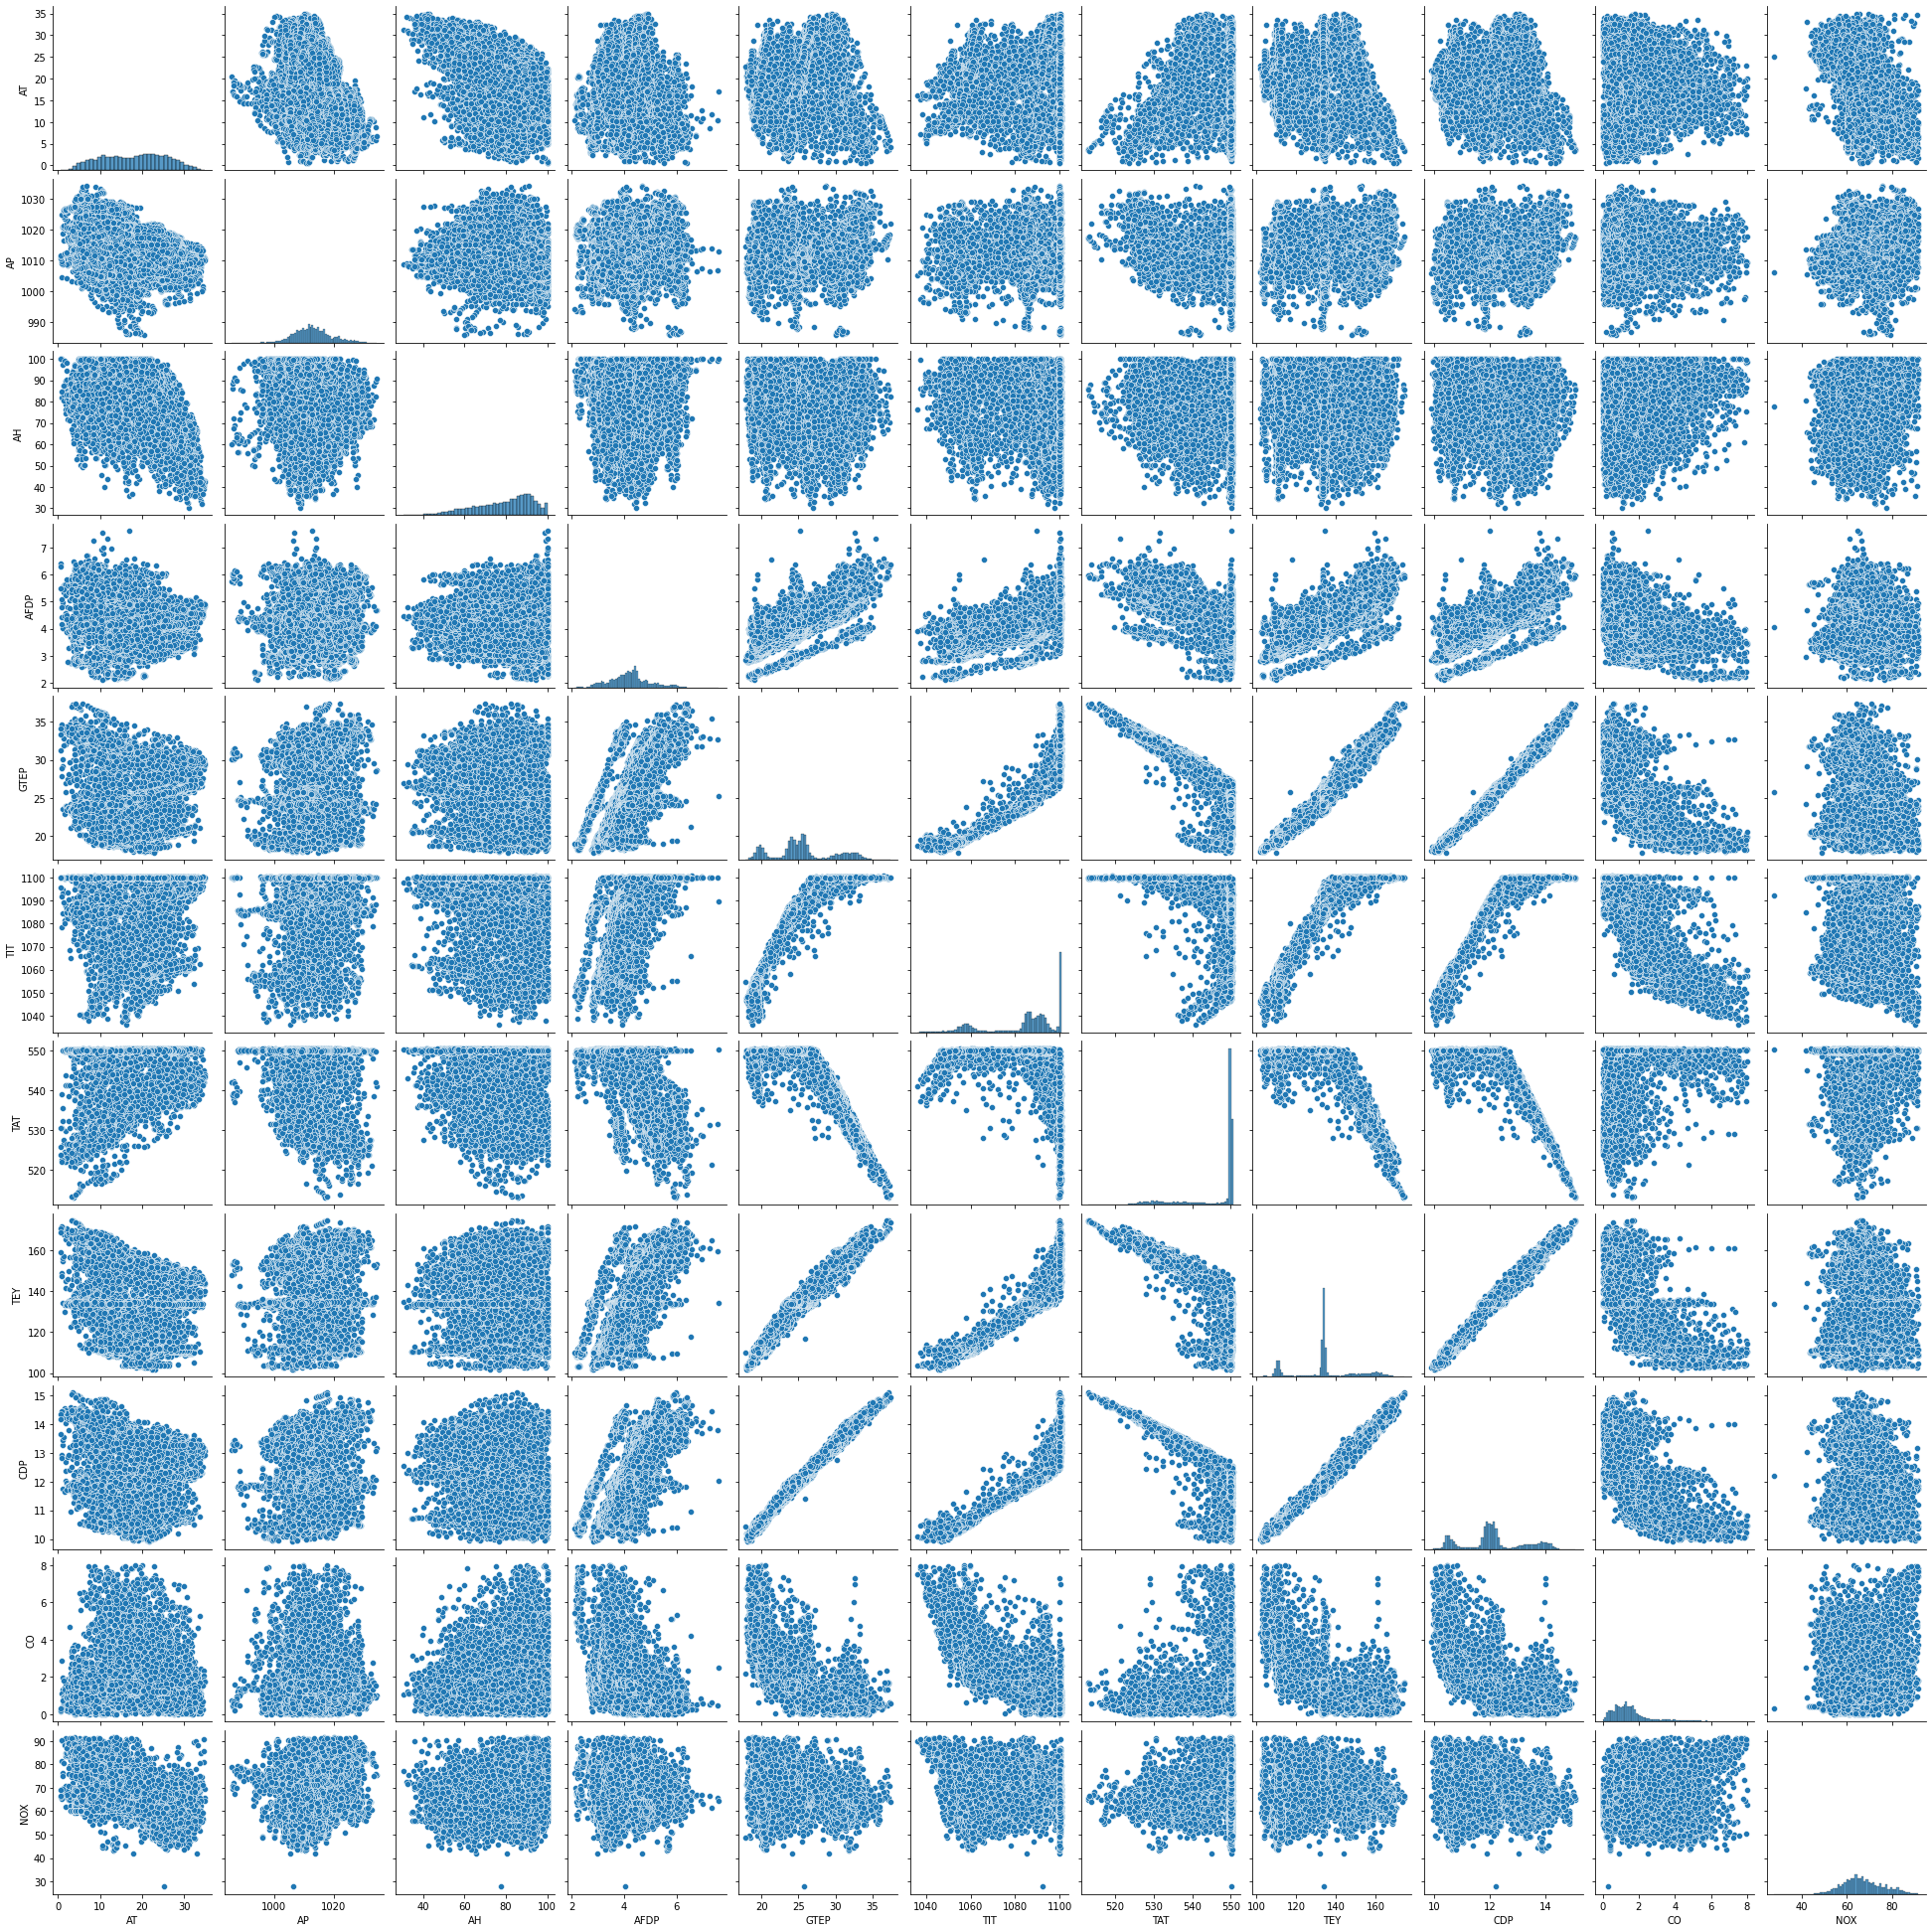

In [15]:
sns.pairplot(df_turbines)

### **Train Test Data Split**

In [16]:
# Separate x and y columns
x = df_turbines.drop('TEY', axis=1)
y = df_turbines['TEY']
print(x.shape)
print(y.shape)

(14546, 10)
(14546,)


In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(10182, 10)
(4364, 10)
(10182,)
(4364,)


In [19]:
# Since data of different range values, convert into Standard Format
scaler = StandardScaler()
#scaler_fit = scaler.fit()
x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.fit_transform(x_test)

## **Neural Networks - Model Building**

In [20]:
# Importing the necessary packages
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout

In [39]:
# Defining the model

def create_model():
    model = Sequential()
    model.add(Dense(64,input_dim = 10, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1,activation = 'linear'))
    
    adam = Adam(lr = 0.001) 
    model.compile(loss = 'mean_squared_error',optimizer = adam,metrics = ['mae'])
    return model

# Create the model

#model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 40,epochs = 100)
model = create_model()

# Fitting the model

history = model.fit(x_train,y_train)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


319/319 [==============================] - 1s 3ms/step - loss: 9625.9561 - mae: 60.3648


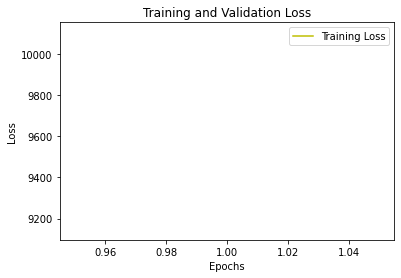

In [40]:
# Plot the training and validation accuracy
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training Loss')
#plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
# Predicting using trained model

y_train_predict = model.predict(x_train)

In [42]:
from sklearn.metrics import mean_squared_error
rmse_train = mean_squared_error(y_train, y_train_predict, squared=False)
print(rmse_train)

14.593334232188619


In [46]:
y_train

11315    111.34
1398     134.02
1310     122.85
9482     132.76
14349    164.71
          ...  
5441     136.37
12602    112.20
1517     138.49
11994    146.08
3790     134.30
Name: TEY, Length: 10182, dtype: float64

In [47]:
y_train_predict

array([[125.42285],
       [129.8677 ],
       [129.35522],
       ...,
       [129.92787],
       [128.5762 ],
       [127.34462]], dtype=float32)

Note: Model got created with RMSEof 14.59 with near value predictions.

## **Predictions for Test Data**

In [48]:
y_test_predict = model.predict(x_test)

In [49]:
rmse_test = mean_squared_error(y_test, y_test_predict, squared=False)
print(rmse_test)

14.573429380560906


In [50]:
y_test

4938     134.00
7402     134.15
12166    113.69
1620     111.73
1295     128.44
          ...  
13244    134.00
1842     112.39
828      163.06
4042     134.28
7477     134.63
Name: TEY, Length: 4364, dtype: float64

In [51]:
y_test_predict

array([[129.16333],
       [130.6941 ],
       [125.723  ],
       ...,
       [133.9651 ],
       [127.12872],
       [131.10385]], dtype=float32)

Observation: Neural Networks model got created with RMSE of 14.57.